<a href="https://colab.research.google.com/github/JoaquinGomezMillan/Capstone/blob/main/Clustering_Joaquin_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer

# time calculation to track some processes
import time

from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ROOT='/content/drive/MyDrive/outputs/dataframes/'
df = pd.read_csv(ROOT+'df_final.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   id              object 
 2   yearweek        int64  
 3   sales_quantity  int64  
 4   item            object 
 5   category        object 
 6   department      object 
 7   store           object 
 8   store_code      object 
 9   region          object 
 10  event           object 
 11  sell_price      float64
 12  date            object 
dtypes: float64(1), int64(3), object(9)
memory usage: 828.6+ MB


In [5]:
df.isnull().sum()

Unnamed: 0              0
id                      0
yearweek                0
sales_quantity          0
item                    0
category                0
department              0
store                   0
store_code              0
region                  0
event             7561520
sell_price        1809443
date                    0
dtype: int64

In [6]:
#Relleno los nulos de la columna event con Ordinary_Day
df['event'].fillna('Ordinary_Day',inplace=True)

In [7]:
df['event'].value_counts()

Ordinary_Day      7561520
SuperBowl          182940
Ramadan starts     152450
Thanksgiving       152450
NewYear            152450
Easter             152450
Name: event, dtype: int64

In [8]:
df['sell_price'].isnull().sum()

1809443

In [9]:
# Relleno sell_price con los últimos precios registrados
df['sell_price']=df.groupby(['store_code','item']).apply(lambda x: x.sell_price.bfill()).reset_index(drop=True)

In [10]:
df['sell_price'].isnull().sum()

0

In [11]:
df.isnull().sum()

Unnamed: 0        0
id                0
yearweek          0
sales_quantity    0
item              0
category          0
department        0
store             0
store_code        0
region            0
event             0
sell_price        0
date              0
dtype: int64

In [12]:
del(df['Unnamed: 0'])

In [13]:
df.isnull().sum()

id                0
yearweek          0
sales_quantity    0
item              0
category          0
department        0
store             0
store_code        0
region            0
event             0
sell_price        0
date              0
dtype: int64

In [14]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
yearweek,8354260.0,201346.251825,151.927907,201104.000,201220.0000,201336.500,201501.000,201616.00
sales_quantity,8354260.0,7.863702,23.680201,0.000,0.0000,2.000,7.000,3976.00
sell_price,8354260.0,5.562642,4.547851,0.012,2.6201,4.176,7.176,134.15


In [15]:
df.describe(exclude=np.number).T

,count,unique,top,freq
id,8354260,30490,ACCESORIES_1_001_BOS_1,274
item,8354260,3049,ACCESORIES_1_001,2740
category,8354260,3,SUPERMARKET,3937380
department,8354260,7,SUPERMARKET_3,2255020
store,8354260,10,South_End,835426
store_code,8354260,10,BOS_1,835426
region,8354260,3,New York,3341704
event,8354260,6,Ordinary_Day,7561520
date,8354260,274,2011-01-30,30490


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   yearweek        int64  
 2   sales_quantity  int64  
 3   item            object 
 4   category        object 
 5   department      object 
 6   store           object 
 7   store_code      object 
 8   region          object 
 9   event           object 
 10  sell_price      float64
 11  date            object 
dtypes: float64(1), int64(2), object(9)
memory usage: 764.9+ MB


In [17]:
df.head()

,id,yearweek,sales_quantity,item,category,department,store,store_code,region,event,sell_price,date
0,ACCESORIES_1_001_BOS_1,201104,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-01-30
1,ACCESORIES_1_001_BOS_1,201105,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,SuperBowl,12.7414,2011-02-06
2,ACCESORIES_1_001_BOS_1,201106,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-13
3,ACCESORIES_1_001_BOS_1,201107,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-20
4,ACCESORIES_1_001_BOS_1,201108,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-27


In [18]:
# Cambio el formato de la columna date a fecha
df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')

In [19]:
df.describe(exclude=np.number).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last
id,8354260,30490,ACCESORIES_1_001_BOS_1,274,NaT,NaT
item,8354260,3049,ACCESORIES_1_001,2740,NaT,NaT
category,8354260,3,SUPERMARKET,3937380,NaT,NaT
department,8354260,7,SUPERMARKET_3,2255020,NaT,NaT
store,8354260,10,South_End,835426,NaT,NaT
store_code,8354260,10,BOS_1,835426,NaT,NaT
region,8354260,3,New York,3341704,NaT,NaT
event,8354260,6,Ordinary_Day,7561520,NaT,NaT
date,8354260,274,2011-01-30 00:00:00,30490,2011-01-30,2016-04-24


In [20]:
df.isnull().sum()

id                0
yearweek          0
sales_quantity    0
item              0
category          0
department        0
store             0
store_code        0
region            0
event             0
sell_price        0
date              0
dtype: int64

In [21]:
# Creación de nuevas variables
df['day']=df['date'].dt.day
df['month']=df['date'].dt.month
df['year']=df['date'].dt.year
df['week']=df['date'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [22]:
df.isnull().sum()

id                0
yearweek          0
sales_quantity    0
item              0
category          0
department        0
store             0
store_code        0
region            0
event             0
sell_price        0
date              0
day               0
month             0
year              0
week              0
dtype: int64

In [26]:
#del(df['date'])
del(df['yearweek'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   sales_quantity  int64         
 2   item            object        
 3   category        object        
 4   department      object        
 5   store           object        
 6   store_code      object        
 7   region          object        
 8   event           object        
 9   sell_price      float64       
 10  date            datetime64[ns]
 11  day             int64         
 12  month           int64         
 13  year            int64         
 14  week            int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(8)
memory usage: 956.1+ MB


In [28]:
df.set_index('id')

,sales_quantity,item,category,department,store,store_code,region,event,sell_price,date,day,month,year,week
id,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-01-30,30,1,2011,4
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,SuperBowl,12.7414,2011-02-06,6,2,2011,5
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-13,13,2,2011,6
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-20,20,2,2011,7
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-27,27,2,2011,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_827_PHI_3,17,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,Easter,1.2000,2016-03-27,27,3,2016,12
SUPERMARKET_3_827_PHI_3,22,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,Ordinary_Day,1.2000,2016-04-03,3,4,2016,13
SUPERMARKET_3_827_PHI_3,8,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,Ordinary_Day,1.2000,2016-04-10,10,4,2016,14


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


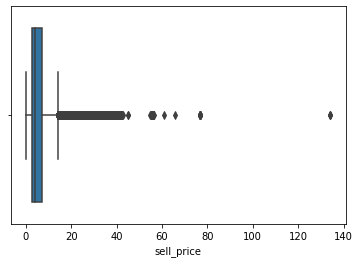

In [29]:
sns.boxplot(df['sell_price'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


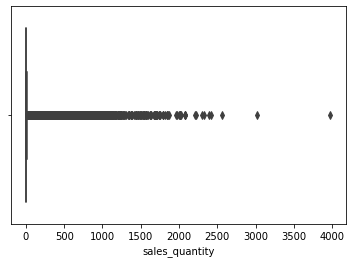

In [30]:
sns.boxplot(df['sales_quantity'])

In [31]:
df_back = df.copy(deep = True)

In [32]:
df_final = df_back.copy(deep = True)

In [33]:
df_final.head()

,id,sales_quantity,item,category,department,store,store_code,region,event,sell_price,date,day,month,year,week
0,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-01-30,30,1,2011,4
1,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,SuperBowl,12.7414,2011-02-06,6,2,2011,5
2,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-13,13,2,2011,6
3,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-20,20,2,2011,7
4,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-27,27,2,2011,8


# Eliminar outliers (sell price)

In [34]:
aggregated_table = df_final.groupby('id').agg(
    max_sales_quantity = ('sales_quantity', 'max'), 
    min_sales_quantity = ('sales_quantity', 'min'),
    mean_sales_quantity=('sales_quantity', 'mean'),

    max_sell_price = ('sell_price', 'max'), 
    min_sell_price = ('sell_price', 'min'), 
    mean_sell_price = ('sell_price', 'mean'), 

    first_sale=('date','min'),
    last_sale=('date','max')

)

In [35]:
df_final_aggregated=pd.merge(df_final, aggregated_table, on = 'id')

In [36]:
df_final_aggregated.head()

,id,sales_quantity,item,category,department,store,store_code,region,event,sell_price,date,day,month,year,week,max_sales_quantity,min_sales_quantity,mean_sales_quantity,max_sell_price,min_sell_price,mean_sell_price,first_sale,last_sale
0,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-01-30,30,1,2011,4,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
1,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,SuperBowl,12.7414,2011-02-06,6,2,2011,5,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
2,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-13,13,2,2011,6,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
3,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-20,20,2,2011,7,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
4,ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-27,27,2,2011,8,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24


In [37]:
# Eliminación de outliers

# creamos los booleanos donde se cumplen que los clientes no son outliers en alguna de las columnas
criteria1 = df_final_aggregated["sales_quantity"] < np.quantile(df_final_aggregated["sales_quantity"], q = 0.99)
criteria2 = df_final_aggregated["sell_price"] < np.quantile(df_final_aggregated["sell_price"], q = 0.99)

# chained operations: juntamos los dos criterios. Por tanto nos quedaremos sólo con los clientes que no son outliers
# en amount y tampoco son outliers en max_delay
criteria_final = criteria1 & criteria2
aggregated_df_no_outliers = df_final_aggregated[criteria_final]

In [38]:
aggregated_df_no_outliers.set_index('id',inplace=True)

In [39]:
aggregated_df_no_outliers.head()

,sales_quantity,item,category,department,store,store_code,region,event,sell_price,date,day,month,year,week,max_sales_quantity,min_sales_quantity,mean_sales_quantity,max_sell_price,min_sell_price,mean_sell_price,first_sale,last_sale
id,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-01-30,30,1,2011,4,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,SuperBowl,12.7414,2011-02-06,6,2,2011,5,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-13,13,2,2011,6,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-20,20,2,2011,7,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24
ACCESORIES_1_001_BOS_1,0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,Ordinary_Day,12.7414,2011-02-27,27,2,2011,8,8,0,0.948905,12.7414,6.65,11.796518,2011-01-30,2016-04-24


In [40]:
del(aggregated_df_no_outliers['item'])
del(aggregated_df_no_outliers['category'])
del(aggregated_df_no_outliers['department'])
del(aggregated_df_no_outliers['store'])
del(aggregated_df_no_outliers['store_code'])
del(aggregated_df_no_outliers['region'])
del(aggregated_df_no_outliers['event'])
del(aggregated_df_no_outliers['sell_price'])
del(aggregated_df_no_outliers['date'])
del(aggregated_df_no_outliers['first_sale'])
del(aggregated_df_no_outliers['last_sale'])


In [41]:
# Escalado de datos
standard_scaler = StandardScaler()
scaled_df_item = standard_scaler.fit_transform(aggregated_df_no_outliers)
scaled_df_item = pd.DataFrame(scaled_df_item, index = aggregated_df_no_outliers.index, columns = aggregated_df_no_outliers.columns)

In [42]:
#scaled_df_item.to_csv('''/content/drive/MyDrive/Colab Notebooks/RETAIL/scaled_df_item.csv''')

# Elbow

In [43]:
# Hecho en el notebook Elbow item_id.ipynb

# Clustering item_id

In [ ]:
# fiteamos un modelo con k = 5 (que hemos sacado de la elbow curve anterior) 
# y con el dataframe escalado y sin outliers

cluster_model = KMeans(n_clusters = 5)
cluster_model.fit(scaled_df_item)